<a href="https://colab.research.google.com/github/JRamos84/deteccion_fraude/blob/main/notebooks/04_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 04 Modeling
**Objetivo**: Construir y evaluar modelos de clasificación.
**Contenido**:

- Carga y preparación de los datos
- División de los datos en conjuntos de entrenamiento y prueba
- Entrenamiento de modelos
- Evaluación de los modelos
- Comparación de resultados

In [7]:
##  Importación de Librerías
import time
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns

In [16]:

def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, cv=5):
    # Asegúrate de que y_train y y_val sean vectores unidimensionales
    y_train = np.ravel(y_train)
    y_val = np.ravel(y_val)

    # Validación cruzada en el conjunto de entrenamiento
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    y_train_pred_cv = cross_val_predict(model, X_train, y_train, cv=cv)

    # Calcular métricas de validación cruzada
    accuracy_cv = cv_scores.mean()
    roc_auc_cv = roc_auc_score(y_train, y_train_pred_cv)

    # Imprimir métricas de validación cruzada
    print(f'Accuracy (CV): {accuracy_cv:.4f}')
    print(f'ROC AUC (CV): {roc_auc_cv:.4f}')
    print('Classification Report (CV):')
    print(classification_report(y_train, y_train_pred_cv))

    # Mostrar la matriz de confusión promediada
    conf_matrix_cv = confusion_matrix(y_train, y_train_pred_cv)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_cv, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (CV)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Entrenar el modelo con los datos de entrenamiento completos
    model.fit(X_train, y_train)

    # Predecir con los datos de validación
    y_val_pred = model.predict(X_val)

    # Calcular métricas en el conjunto de validación
    accuracy_val = accuracy_score(y_val, y_val_pred)
    roc_auc_val = roc_auc_score(y_val, y_val_pred)

    # Imprimir métricas del conjunto de validación
    print(f'Accuracy (Validation): {accuracy_val:.4f}')
    print(f'ROC AUC (Validation): {roc_auc_val:.4f}')
    print('Classification Report (Validation):')
    print(classification_report(y_val, y_val_pred))

    # Mostrar la matriz de confusión del conjunto de validación
    conf_matrix_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Retornar el modelo entrenado
    return model


def train_xgboost_model(X_train, y_train, X_val, y_val, params, num_rounds=100, threshold=0.5):
    # Convertir datos a DMatrix (formato optimizado para XGBoost)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Entrenar el modelo
    model = xgb.train(params, dtrain, num_rounds)

    # Predecir probabilidades en el conjunto de validación
    y_pred_proba = model.predict(dval)

    # Convertir probabilidades a etiquetas binarias
    y_pred_binary = [1 if p > threshold else 0 for p in y_pred_proba]

    # Calcular la precisión en el conjunto de validación
    accuracy = accuracy_score(y_val, y_pred_binary)
    print(f'Precisión en el conjunto de validación (Accuracy): {accuracy:.2f}')

    # Calcular el área bajo la curva ROC (ROC AUC)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    print(f'Área bajo la curva ROC (ROC AUC): {roc_auc:.2f}')

    # Imprimir el reporte de clasificación en el conjunto de validación
    print('Classification Report (Validation):')
    print(classification_report(y_val, y_pred_binary))

    # Mostrar la matriz de confusión en el conjunto de validación
    conf_matrix = confusion_matrix(y_val, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión (Validation)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()




In [3]:
## Importamos las librerias a usar
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection'


Mounted at /content/drive


## Carga y Preparación de los Datos

In [4]:
# Guardar X y y en archivos CSV

#dir_data_processed = '../data/processed'
dir_data_processed = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/processed'
ruta_archivo_X_train = os.path.join(dir_data_processed, 'X__train_procesados.csv')
ruta_archivo_X_test = os.path.join(dir_data_processed, 'X_test_procesados.csv')
ruta_archivo_X_val = os.path.join(dir_data_processed, 'X_val_procesados.csv')

ruta_archivo_y_train = os.path.join(dir_data_processed, 'y_train_procesados.csv')
ruta_archivo_y_test = os.path.join(dir_data_processed, 'y_test_procesados.csv')
ruta_archivo_y_val = os.path.join(dir_data_processed, 'y_val_procesados.csv')


X_train_final= pd.read_csv(ruta_archivo_X_train)
X_val_final= pd.read_csv(ruta_archivo_X_val)
X_test_final= pd.read_csv(ruta_archivo_X_test)

y_train_final= pd.read_csv(ruta_archivo_y_train)
y_val_final= pd.read_csv(ruta_archivo_y_val)
y_test_final= pd.read_csv(ruta_archivo_y_test)



In [5]:
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

print(y_train_final.shape)
print(y_val_final.shape)
print(y_test_final.shape)

(242811, 184)
(52031, 184)
(52032, 184)
(242811, 1)
(52031, 1)
(52032, 1)


### Recuperación de lista de nombres de columnas por *Feature Selection*

In [45]:
dir_data_processed = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection/processed'
ruta_archivo_columns = os.path.join(dir_data_processed, 'columns_feature_selection.pkl')
with open(ruta_archivo_columns, 'rb') as file:
    cat_cols_selected , col_selected_num = pickle.load(file)

print('num_cols_feature_selection:', col_selected_num )
print('cat_cols_feature_selection:', cat_cols_selected )


num_cols_feature_selection: ['V283', 'V281', 'V280', 'V282', 'V279', 'V295', 'V308', 'V293', 'V312', 'V307', 'V95', 'V292', 'V97', 'V315', 'V318', 'V289', 'V317', 'V128', 'V101', 'V103', 'V62', 'V291', 'V294', 'V313', 'V314', 'V56', 'V288', 'V29', 'V131', 'V90', 'V69', 'V284', 'V30', 'V127', 'V91', 'V74', 'V70', 'V134', 'V290', 'V133', 'V287', 'V67', 'V33', 'V34', 'V94', 'V309', 'V98', 'V310', 'V102', 'V306', 'V73', 'V78', 'V83', 'V100', 'V55', 'V316', 'TransactionAmt', 'V96', 'V20', 'V126', 'V296', 'V298', 'V61', 'V130', 'V129', 'V54', 'V132']
cat_cols_feature_selection: ['card6', '_Days', '_Hours']


In [46]:
len(col_selected_num) + len(cat_cols_selected)

70

### Selección de un Subconjunto Estratificado

Seleccionamos una porción de los datos de entrenamiento para evaluar de manera óptima el modelo y realizar el análisis PCA.

In [ ]:
# Definir la fracción del conjunto de datos para preentrenamiento
fraction = 0.5  # 10%


y = np.ravel(y_train_final)

# Dividir el conjunto de datos para obtener el subconjunto estratificado
X_pretrain, _, y_pretrain, _ = train_test_split(X_train_final, y, train_size=fraction, stratify=y, random_state=42)

# Verificar las proporciones de las clases
print("Proporción de clases en el conjunto original:", np.bincount(y) / len(y))
print("Proporción de clases en el subconjunto de preentrenamiento:", np.bincount(y_pretrain) / len(y_pretrain))
print(f"Tamaño del subconjunto de preentrenamiento: {len(y_pretrain)} muestras")

### Balanceo de muestra

In [ ]:
## Balanceo sin PCA
undersampler = RandomUnderSampler(random_state=42)
X_pretrain_B, y_pretrain_B,= undersampler.fit_resample(X_pretrain, y_pretrain)
# Mostrar la distribución de clases después del submuestreo
X_pretrain_B.shape, y_pretrain_B.shape

In [ ]:
unique, counts = np.unique(y_pretrain_B, return_counts=True)

# Crear un diccionario para mostrar los resultados
value_counts = dict(zip(unique, counts))
print(value_counts)

### Uso de la Validación Cruzada para Determinar el Número de Componentes en PCA

In [17]:
# Inicia el cronómetro

# Número máximo de componentes principales (puede ser el número de características)
#max_components = X_pretrain.shape[1]
max_components = 50
# Inicializar la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inicializar el modelo de clasificación
classifier = RandomForestClassifier(random_state=42)

# Array para almacenar los scores de validación cruzada
cv_scores = []

# Realizar PCA y validación cruzada para diferentes números de componentes
for n_components in range(1, max_components + 1):
    #start_time = time.time()
    # Aplicar PCA

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_pretrain_B)

    # Evaluar el modelo con validación cruzada
    scores = cross_val_score(classifier, X_pca, np.ravel(y_pretrain_B), cv=cv, scoring='accuracy')

    # Guardar el promedio de los scores
    cv_scores.append(scores.mean())
    # print(f'PCA con {n_components} componentes')
    # print(f'Accuracy promedio: {scores.mean():.4f} ± {scores.std():.4f}')
    # end_time = time.time()
    # elapsed_time = end_time - start_time
    # print(f"El tiempo de entrenamiento fue de {elapsed_time:.2f} segundos")

# Determinar el número óptimo de componentes
optimal_components = np.argmax(cv_scores) + 1
optimal_scores_mean = cv_scores[optimal_components - 1]  # Aquí se ajusta correctamente el índice
print(f'Número óptimo de componentes: {optimal_components}')
print(f'Score de validación cruzada con {optimal_components} componentes: {cv_scores[optimal_components - 1]}')
print(f'Accuracy promedio: {optimal_scores_mean:.4f}')

# Graficar los scores de validación cruzada
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), cv_scores, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Accuracy')
plt.title('Validación Cruzada para PCA y Clasificación Binaria')
plt.show()


NameError: name 'X_pretrain_B' is not defined

- Utilizando datos estratificados al 50%, se determinó que 26 componentes principales es un valor adecuado para el entrenamiento del modelo.

In [18]:
## Balanceo de X_train y y_train totales
undersampler = RandomUnderSampler(random_state=42)
X_train_B, y_train_B,= undersampler.fit_resample(X_train_final, y_train_final)
# Mostrar la distribución de clases después del submuestreo
X_train_B.shape, y_train_B.shape

((9716, 184), (9716, 1))

In [19]:
unique, counts = np.unique(y_train_B, return_counts=True)

# Crear un diccionario para mostrar los resultados
value_counts = dict(zip(unique, counts))
print(value_counts)

{0: 4858, 1: 4858}


In [20]:
## Balanceo y pca

pca = PCA(n_components=26)  # Mantener el 95% de la varianza explicada
X_train_pca_B = pca.fit_transform(X_train_B)
X_val_pca_B = pca.transform(X_val_final)


### Comparación de modelos de entrenamiento

In [21]:

# Definir los modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# Evaluar cada modelo con validación cruzada
for name, model in models.items():
    # Calcular Accuracy
    start_time = time.time()
    accuracy_scores = cross_val_score(model, X_train_pca_B, np.ravel(y_train_B), cv=5, scoring='accuracy')

    # Calcular ROC AUC
    roc_auc_scores = cross_val_score(model, X_train_pca_B, np.ravel(y_train_B), cv=5, scoring='roc_auc')

    # Imprimir resultados
    print(f"{name}:")
    print(f"  Accuracy: {accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}")
    print(f"  ROC AUC: {roc_auc_scores.mean():.4f} ± {roc_auc_scores.std():.4f}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"El tiempo de entrenamiento fue de {elapsed_time:.2f} segundos")


Logistic Regression:
  Accuracy: 0.7176 ± 0.0092
  ROC AUC: 0.7928 ± 0.0069
El tiempo de entrenamiento fue de 3.20 segundos
Random Forest:
  Accuracy: 0.7897 ± 0.0104
  ROC AUC: 0.8706 ± 0.0071
El tiempo de entrenamiento fue de 51.41 segundos
KNN:
  Accuracy: 0.5920 ± 0.0099
  ROC AUC: 0.6206 ± 0.0100
El tiempo de entrenamiento fue de 2.39 segundos
Naive Bayes:
  Accuracy: 0.6643 ± 0.0102
  ROC AUC: 0.7447 ± 0.0091
El tiempo de entrenamiento fue de 0.09 segundos


- El modelo con las mejores métricas es Random Forest, pero su tiempo de entrenamiento es significativamente mayor que el de los demás modelos. Es importante tener en cuenta este factor.

### Entrenamiento con Random Forest

### Datos balanceados

Accuracy (CV): 0.7845
ROC AUC (CV): 0.7845
Classification Report (CV):
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      4858
           1       0.79      0.78      0.78      4858

    accuracy                           0.78      9716
   macro avg       0.78      0.78      0.78      9716
weighted avg       0.78      0.78      0.78      9716



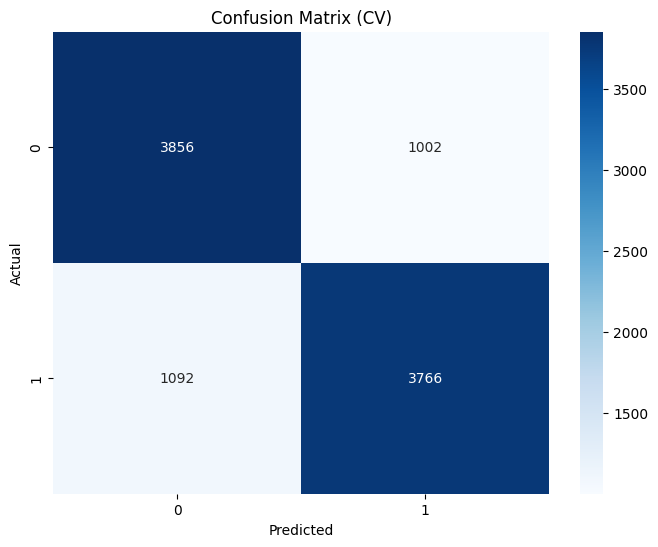

Accuracy (Validation): 0.8027
ROC AUC (Validation): 0.7850
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     50990
           1       0.07      0.77      0.13      1041

    accuracy                           0.80     52031
   macro avg       0.53      0.78      0.51     52031
weighted avg       0.98      0.80      0.87     52031



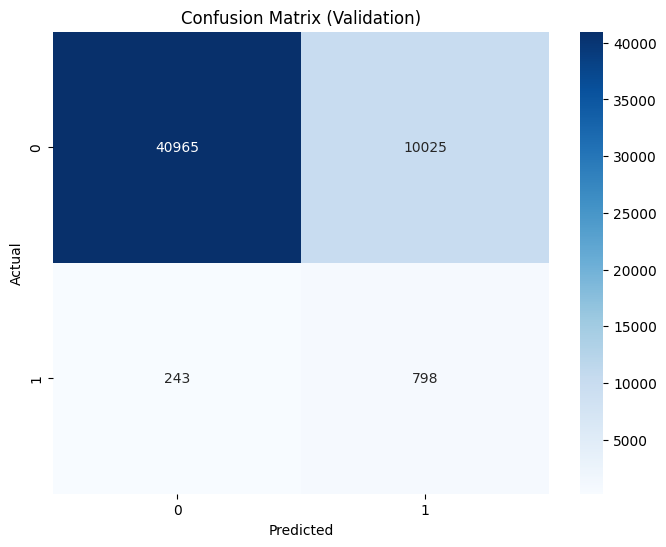

In [27]:
rf_clf = train_and_evaluate_model(RandomForestClassifier(random_state=42), X_train_B, y_train_B, X_val_final, y_val_final)

<ipython-input-53-3ac8a6bee0e4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')


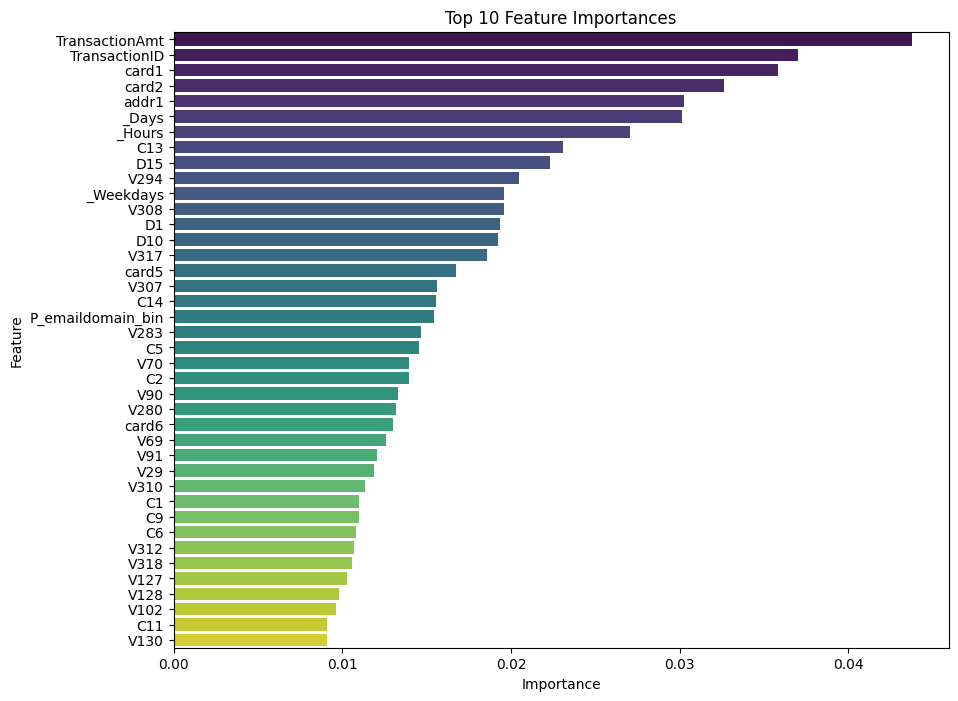

In [53]:

feature_importance = rf_clf.feature_importances_

# Obtener nombres de las características
feature_names = X_train_final.columns

# Crear un DataFrame para visualización
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar por importancia de forma descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las 10 características más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

#### Datos Balanceados con PCA

Accuracy (CV): 0.7897
ROC AUC (CV): 0.7897
Classification Report (CV):
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      4858
           1       0.79      0.78      0.79      4858

    accuracy                           0.79      9716
   macro avg       0.79      0.79      0.79      9716
weighted avg       0.79      0.79      0.79      9716



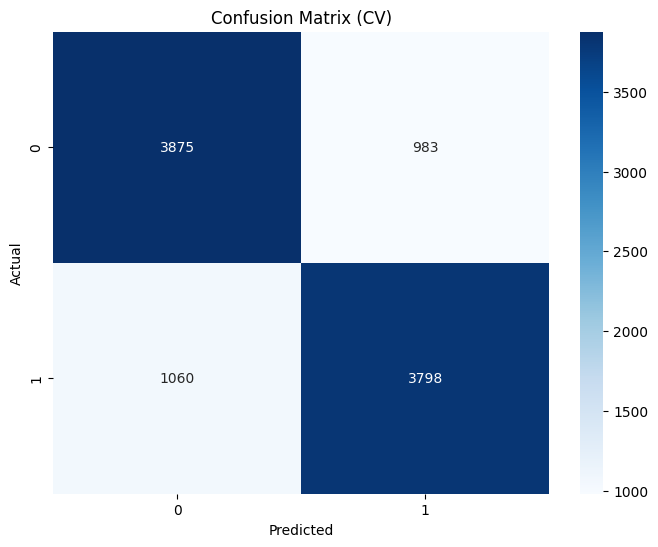

Accuracy (Validation): 0.8135
ROC AUC (Validation): 0.7976
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.81      0.90     50990
           1       0.08      0.78      0.14      1041

    accuracy                           0.81     52031
   macro avg       0.54      0.80      0.52     52031
weighted avg       0.98      0.81      0.88     52031



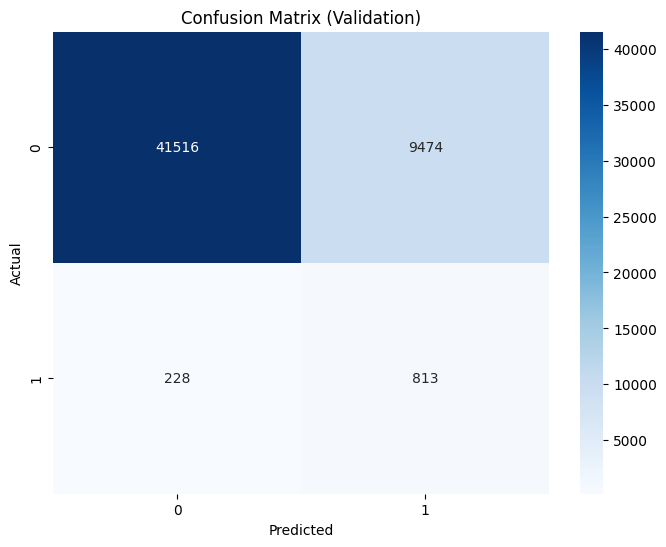

In [49]:
rf_clf_PCA = train_and_evaluate_model(RandomForestClassifier(random_state=42), X_train_pca_B, y_train_B, X_val_pca_B, y_val_final)

<ipython-input-55-62dd7dbb4266>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=original_feature_importance_df.head(26), palette='viridis')


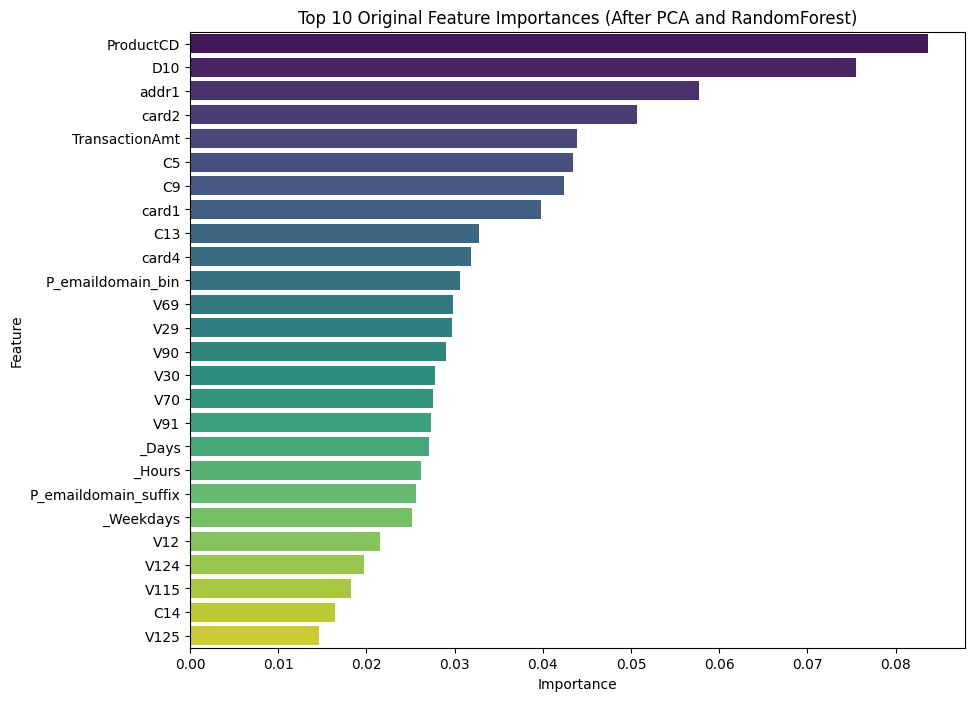

In [55]:

# Obtener las importancias de las componentes principales del modelo RandomForest
feature_importance_pca = rf_clf_PCA.feature_importances_

# Obtener las cargas de las características originales en las componentes principales
components = pca.components_

# Crear un DataFrame para visualización de las cargas de las características originales en las componentes principales
component_names = [f"PC{i+1}" for i in range(components.shape[0])]
feature_names = X_train_final.columns
component_df = pd.DataFrame(components, columns=feature_names, index=component_names)

# Calcular la importancia relativa de las características originales
original_feature_importance = np.abs(component_df.T @ feature_importance_pca)

# Crear un DataFrame para visualización de la importancia relativa de las características originales
original_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': original_feature_importance})
original_feature_importance_df = original_feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las 10 características originales más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=original_feature_importance_df.head(26), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Original Feature Importances (After PCA and RandomForest)')
plt.show()


### Entrenamiento Con Xbgboost

Precisión en el conjunto de validación (Accuracy): 0.75
Área bajo la curva ROC (ROC AUC): 0.76
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.75      0.85     50990
           1       0.05      0.64      0.09      1041

    accuracy                           0.75     52031
   macro avg       0.52      0.69      0.47     52031
weighted avg       0.97      0.75      0.84     52031



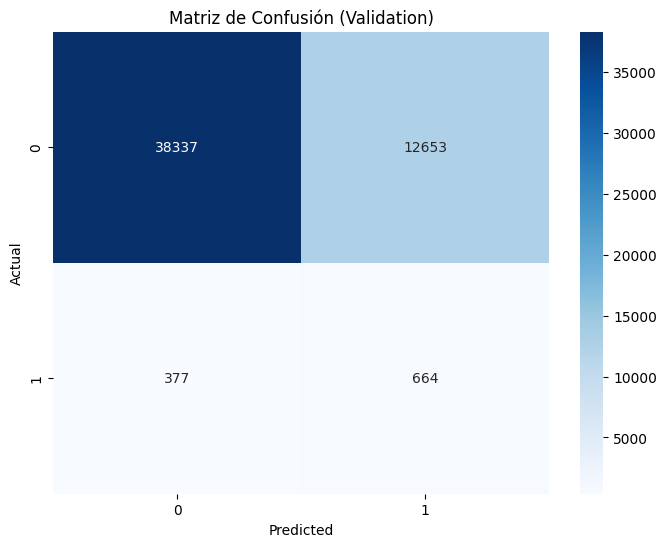

In [23]:

params = {
    'eta': 0.0001,
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc']
}
train_xgboost_model(X_train_pca_B, y_train_B, X_val_pca_B, y_val_final, params)

<ipython-input-48-3ac8a6bee0e4>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')


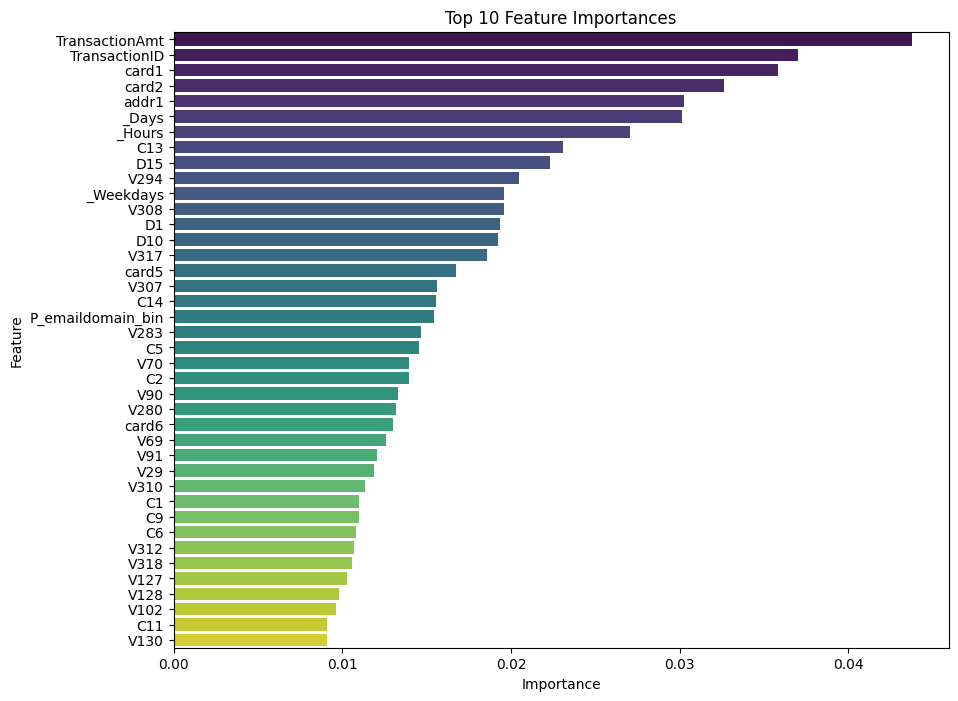

### Utilizando *Feature Selection* en el en entrenamiento

In [44]:
len(col_selected_num) + len(cat_cols_selected)

51

Accuracy (CV): 0.7417
ROC AUC (CV): 0.7417
Classification Report (CV):
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      4858
           1       0.74      0.74      0.74      4858

    accuracy                           0.74      9716
   macro avg       0.74      0.74      0.74      9716
weighted avg       0.74      0.74      0.74      9716



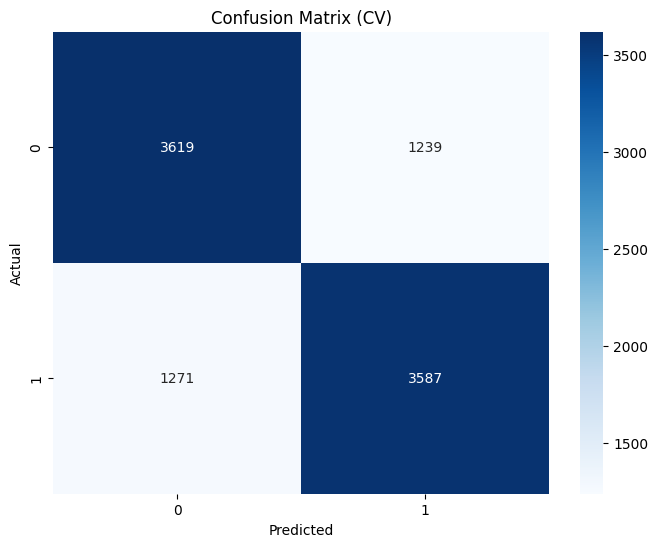

Accuracy (Validation): 0.7510
ROC AUC (Validation): 0.7417
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.75      0.86     50990
           1       0.06      0.73      0.11      1041

    accuracy                           0.75     52031
   macro avg       0.52      0.74      0.48     52031
weighted avg       0.97      0.75      0.84     52031



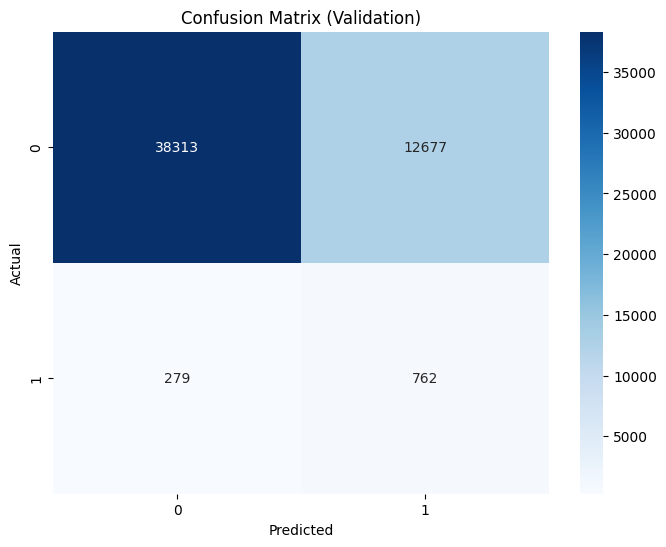

In [47]:
X_train_selection = X_train_B[col_selected_num + cat_cols_selected]
X_val_selection = X_val_final[col_selected_num + cat_cols_selected]
rf_clf_selection = train_and_evaluate_model(RandomForestClassifier(random_state=42), X_train_selection, y_train_B, X_val_selection, y_val_final)

<ipython-input-54-77f8bb4e8367>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')


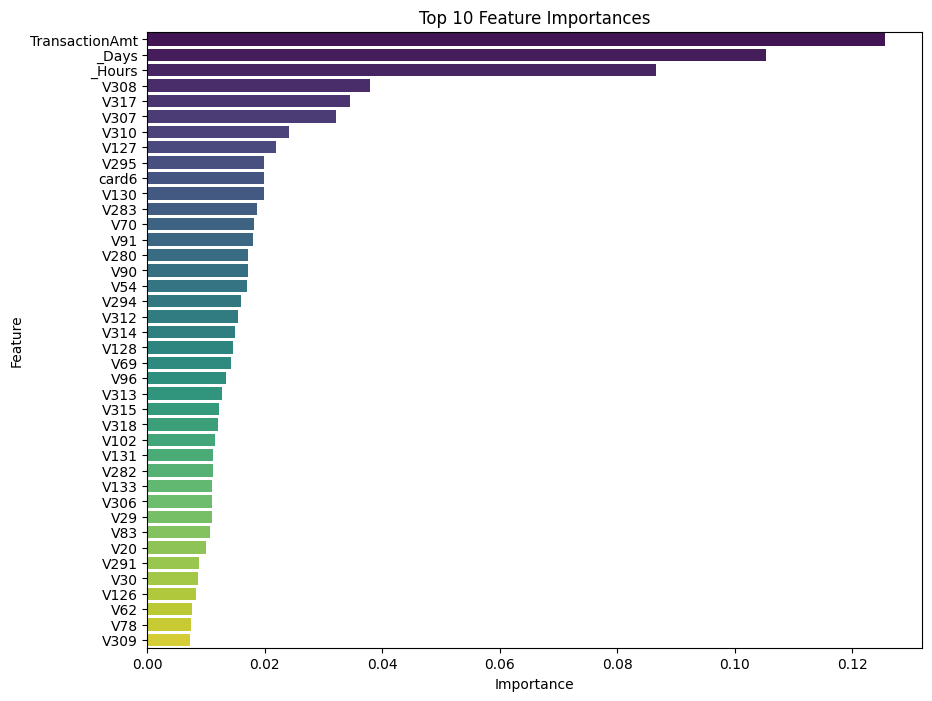

In [54]:

feature_importance = rf_clf_selection .feature_importances_

# Obtener nombres de las características
feature_names = X_train_selection.columns

# Crear un DataFrame para visualización
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Ordenar por importancia de forma descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar las 10 características más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(40), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()

Se puede observar que el rendimiento varía según el rango de TransactionAmt tanto para los modelos de Random Forest como para XGBoost.

## Conclusión
-   Se separaron los datos procesados en conjuntos de entrenamiento, validación y prueba.
-   Los datos de entrenamiento fueron balanceados utilizando submuestreo (undersampling).
-   Se entrenaron tres modelos diferentes de clasificación supervisada: Logistic Regression, Random Forest y XGBoost, evaluando métricas clave para la clasificación binaria de fraude y no fraude.
-   El modelo de Random Forest obtuvo las mejores métricas con un AUC de 0.74, seguido por XGBoost con un AUC de 0.64 y Logistic Regression con un AUC de 0.56. Aunque la exactitud (accuracy) de XGBoost fue mayor que la de Random Forest, el AUC es una métrica más relevante para evaluar la capacidad del modelo para distinguir entre eventos fraudulentos y no fraudulentos.
- AUC y Recall: En problemas de fraude, el AUC y el recall de la clase fraudulenta son cruciales. Un alto recall para la clase de fraude significa que el modelo detecta la mayoría de los casos de fraude, lo cual es vital en este contexto.
    - Recall (Sensibilidad o Recall):
    El recall para la clase "No Fraude" es moderado, lo que significa que el modelo identifica correctamente el 73% de los casos de no fraude. Para la clase "Fraude", el recall es sorprendentemente alto (0.77), indicando que el modelo detecta una buena cantidad de los casos de fraude, aunque con baja precisión.
- Se puede observar que el rendimiento varía según el rango de TransactionAmt tanto para los modelos de Random Forest como para XGBoost.  
### Resultados

| Modelo              | AUC  | Accuracy |
|---------------------|------|----------|
| Random Forest       | 0.74 | 0.72     |
| XGBoost             | 0.64 | 0.76     |
| Logistic Regression | 0.56 | 0.69     |

**Nota:** El AUC (Área Bajo la Curva ROC) es especialmente importante en la detección de fraude, ya que mide la capacidad del modelo para separar correctamente las clases de fraude y no fraude. Aunque XGBoost mostró una mayor exactitud, el modelo de Random Forest fue superior en términos de AUC, lo que indica una mejor discriminación entre eventos fraudulentos y no fraudulentos.
